# Supplemental Figures

### imports

In [45]:
# imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import fcluster, linkage

import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from rna_secstruct_design.selection import get_selection, SecStruct

from qmap_paper.plotting import (
    plot_pop_avg_from_row, find_stretches, fill_between, plot_pop_avg, publication_style_ax, 
    publication_scatter, publication_line)

from qmap_paper.data_processing import get_dms_reactivity_for_sub_structure, SequenceStructure


# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
plt.rcParams["figure.facecolor"] = "white"

In [14]:
DATA_PATH = "../../data/"

### load data

In [16]:
df_wt_mg = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/wt_mg_titra.json")
df_wt_buff = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/wt_buffer_titra.json")
df_mttr6_muts = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/mttr6_muts_titra.json")
df_mttr6_full = pd.read_json(f"{DATA_PATH}/sequencing_runs/processed/mttr6_data_full.json")
df_dg = pd.read_csv(f"{DATA_PATH}/mg_1_2_fits/mtt6_data_mg_1_2_final.csv")

# df_mg_1_2 = pd.read_csv(f"{DATA_PATH}/processed/mtt6_data_mg_1_2_final.csv")
# df_dg = pd.read_csv(f"{LIB_PATH}/resources/csvs/ttr_mutation_dgs_subset.csv")
# df_dg_new = pd.read_csv(f"{LIB_PATH}/resources/csvs/rna_map_dg.csv")

### extra functions

In [50]:
# style functions
def r2(x, y):
    return round(stats.pearsonr(x, y)[0] ** 2, 3)

# how to do highlights
def get_highlight_bounds(sequence, structure, highlights):
    highlight_bounds = []
    secstruct = SecStruct(sequence, structure)
    for h in highlights:
        selection = get_selection(secstruct, h)
        for bounds in find_stretches(selection):
            highlight_bounds.append(bounds)
    return highlight_bounds

def compare_all_nuc_motifs(dfs, seq, name, ylim=0.15):
    seq = "".join(seq.split("&"))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    num_plots = sum(1 for i in range(len(seq)) if seq[i] not in ("G", "U", "&"))
    grid_size = math.ceil(math.sqrt(num_plots))
    
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(grid_size, grid_size)
    
    count = 0 
    gs = [gs[i, j] for i in range(grid_size) for j in range(grid_size)]
    
    for i in range(len(seq)):
        if seq[i] == "G" or seq[i] == "U" or seq[i] == "&":
            continue
        ax = fig.add_subplot(gs[count])
        publication_style_ax(ax)
        for j, df in enumerate(dfs):
            publication_line(ax, df['mg_conc'], df[name].apply(lambda x: x[i]), marker='o', color=colors[j])
        ax.set_title(seq[i] + str(i+1))
        ax.set_ylim([0, ylim])
        count += 1

    fig.text(0.5, 0.00, "[Mg$^{2+}$] (mM)", ha='center', va='center', size=30)
    fig.text(-0.02, 0.5, 'Mutation Fraction', ha='center', va='center', rotation='vertical', size=30)
    fig.tight_layout()

def plot_sequences_by_mutation(wt_seq, mut_seqs, figsize=(2, 1.5)):
    
    # Define the mutation colors
    color_mapping = {
        'A': 'red',
        'C': 'blue',
        'G': 'yellow',
        'T': 'green',
        'U': 'green'
    }
    # Prepare a DataFrame to hold the sequences
    df = pd.DataFrame(mut_seqs, columns=['sequence'])
    df['sequence'] = df['sequence'].apply(list)
    sequence_length = len(wt_seq)

    # Create a matrix for the heatmap
    heatmap_data = np.empty((len(mut_seqs), sequence_length), dtype=object)
    for i, seq in enumerate(mut_seqs):
        for j, (wt_char, seq_char) in enumerate(zip(wt_seq, seq)):
            if wt_char == seq_char:
                heatmap_data[i, j] = wt_char
            else:
                heatmap_data[i, j] = seq_char
    # Convert the matrix to a DataFrame
    heatmap_df = pd.DataFrame(heatmap_data, columns=list(wt_seq))
    # Create a custom colormap
    custom_cmap = ListedColormap(['white', 'red', 'blue', 'yellow', 'green'])

    # Create a color matrix for the heatmap
    color_matrix = np.empty((len(mut_seqs), sequence_length), dtype=object)
    for i in range(len(mut_seqs)):
        for j in range(sequence_length):
            if heatmap_data[i, j] == wt_seq[j]:
                color_matrix[i, j] = 'white'
            else:
                color_matrix[i, j] = color_mapping[heatmap_data[i, j]]

    # Plot the heatmap 
    plt.figure(figsize=figsize)  # Adjust figsize to shrink the boxes
    ax = sns.heatmap(np.zeros_like(heatmap_df, dtype=float), annot=heatmap_data, fmt='', 
                     cmap=custom_cmap, cbar=False, linewidths=0.5, linecolor='black',
                    annot_kws={"size": 14})
    for i in range(len(mut_seqs)):
        for j in range(sequence_length):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))

    # Customize the plot
    #ax.set_xticks(np.arange(sequence_length) + 0.5)
    #ax.set_xticklabels(list(wt_seq), rotation=90, fontsize=8)
    #ax.set_yticks(np.arange(len(mut_seqs)) + 0.5)
    #ax.set_yticklabels([f"Seq {i+1}" for i in range(len(mut_seqs))], rotation=0, fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.xlabel("Position", fontsize=10)
    plt.ylabel("Sequence", fontsize=10)


def generate_pymol_file(data, pymol_data_file):
    """
    generate the pymol file for a single row
    """
    with open(pymol_data_file, "w") as f:
        for i, d in enumerate(data):
            d = d*25
            f.write(f"{i+1} {d} {d}\n")


## actual plots

### Supplemental Figure 3: 50 mM sodium cacodylate correctly captures the unformed state of the tetraloop/ tetraloop receptor contact. 

In [8]:
wt_w_o_mg = df_wt_mg[(df_wt_mg.mg_conc == 0) & (df_wt_mg.exp_name == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM")].iloc[0]
uucg_w_o_mg = df_mttr6_muts[(df_mttr6_muts.mg_conc == 0) & (df_mttr6_muts.name == "minittr_6_uucg_fixed")].iloc[0]
no_tlr_w_o_mg = df_mttr6_muts[(df_mttr6_muts.mg_conc == 0) & (df_mttr6_muts.name == "minittr_6_no_tlr_fixed")].iloc[0]


(-4.0, 94.0)

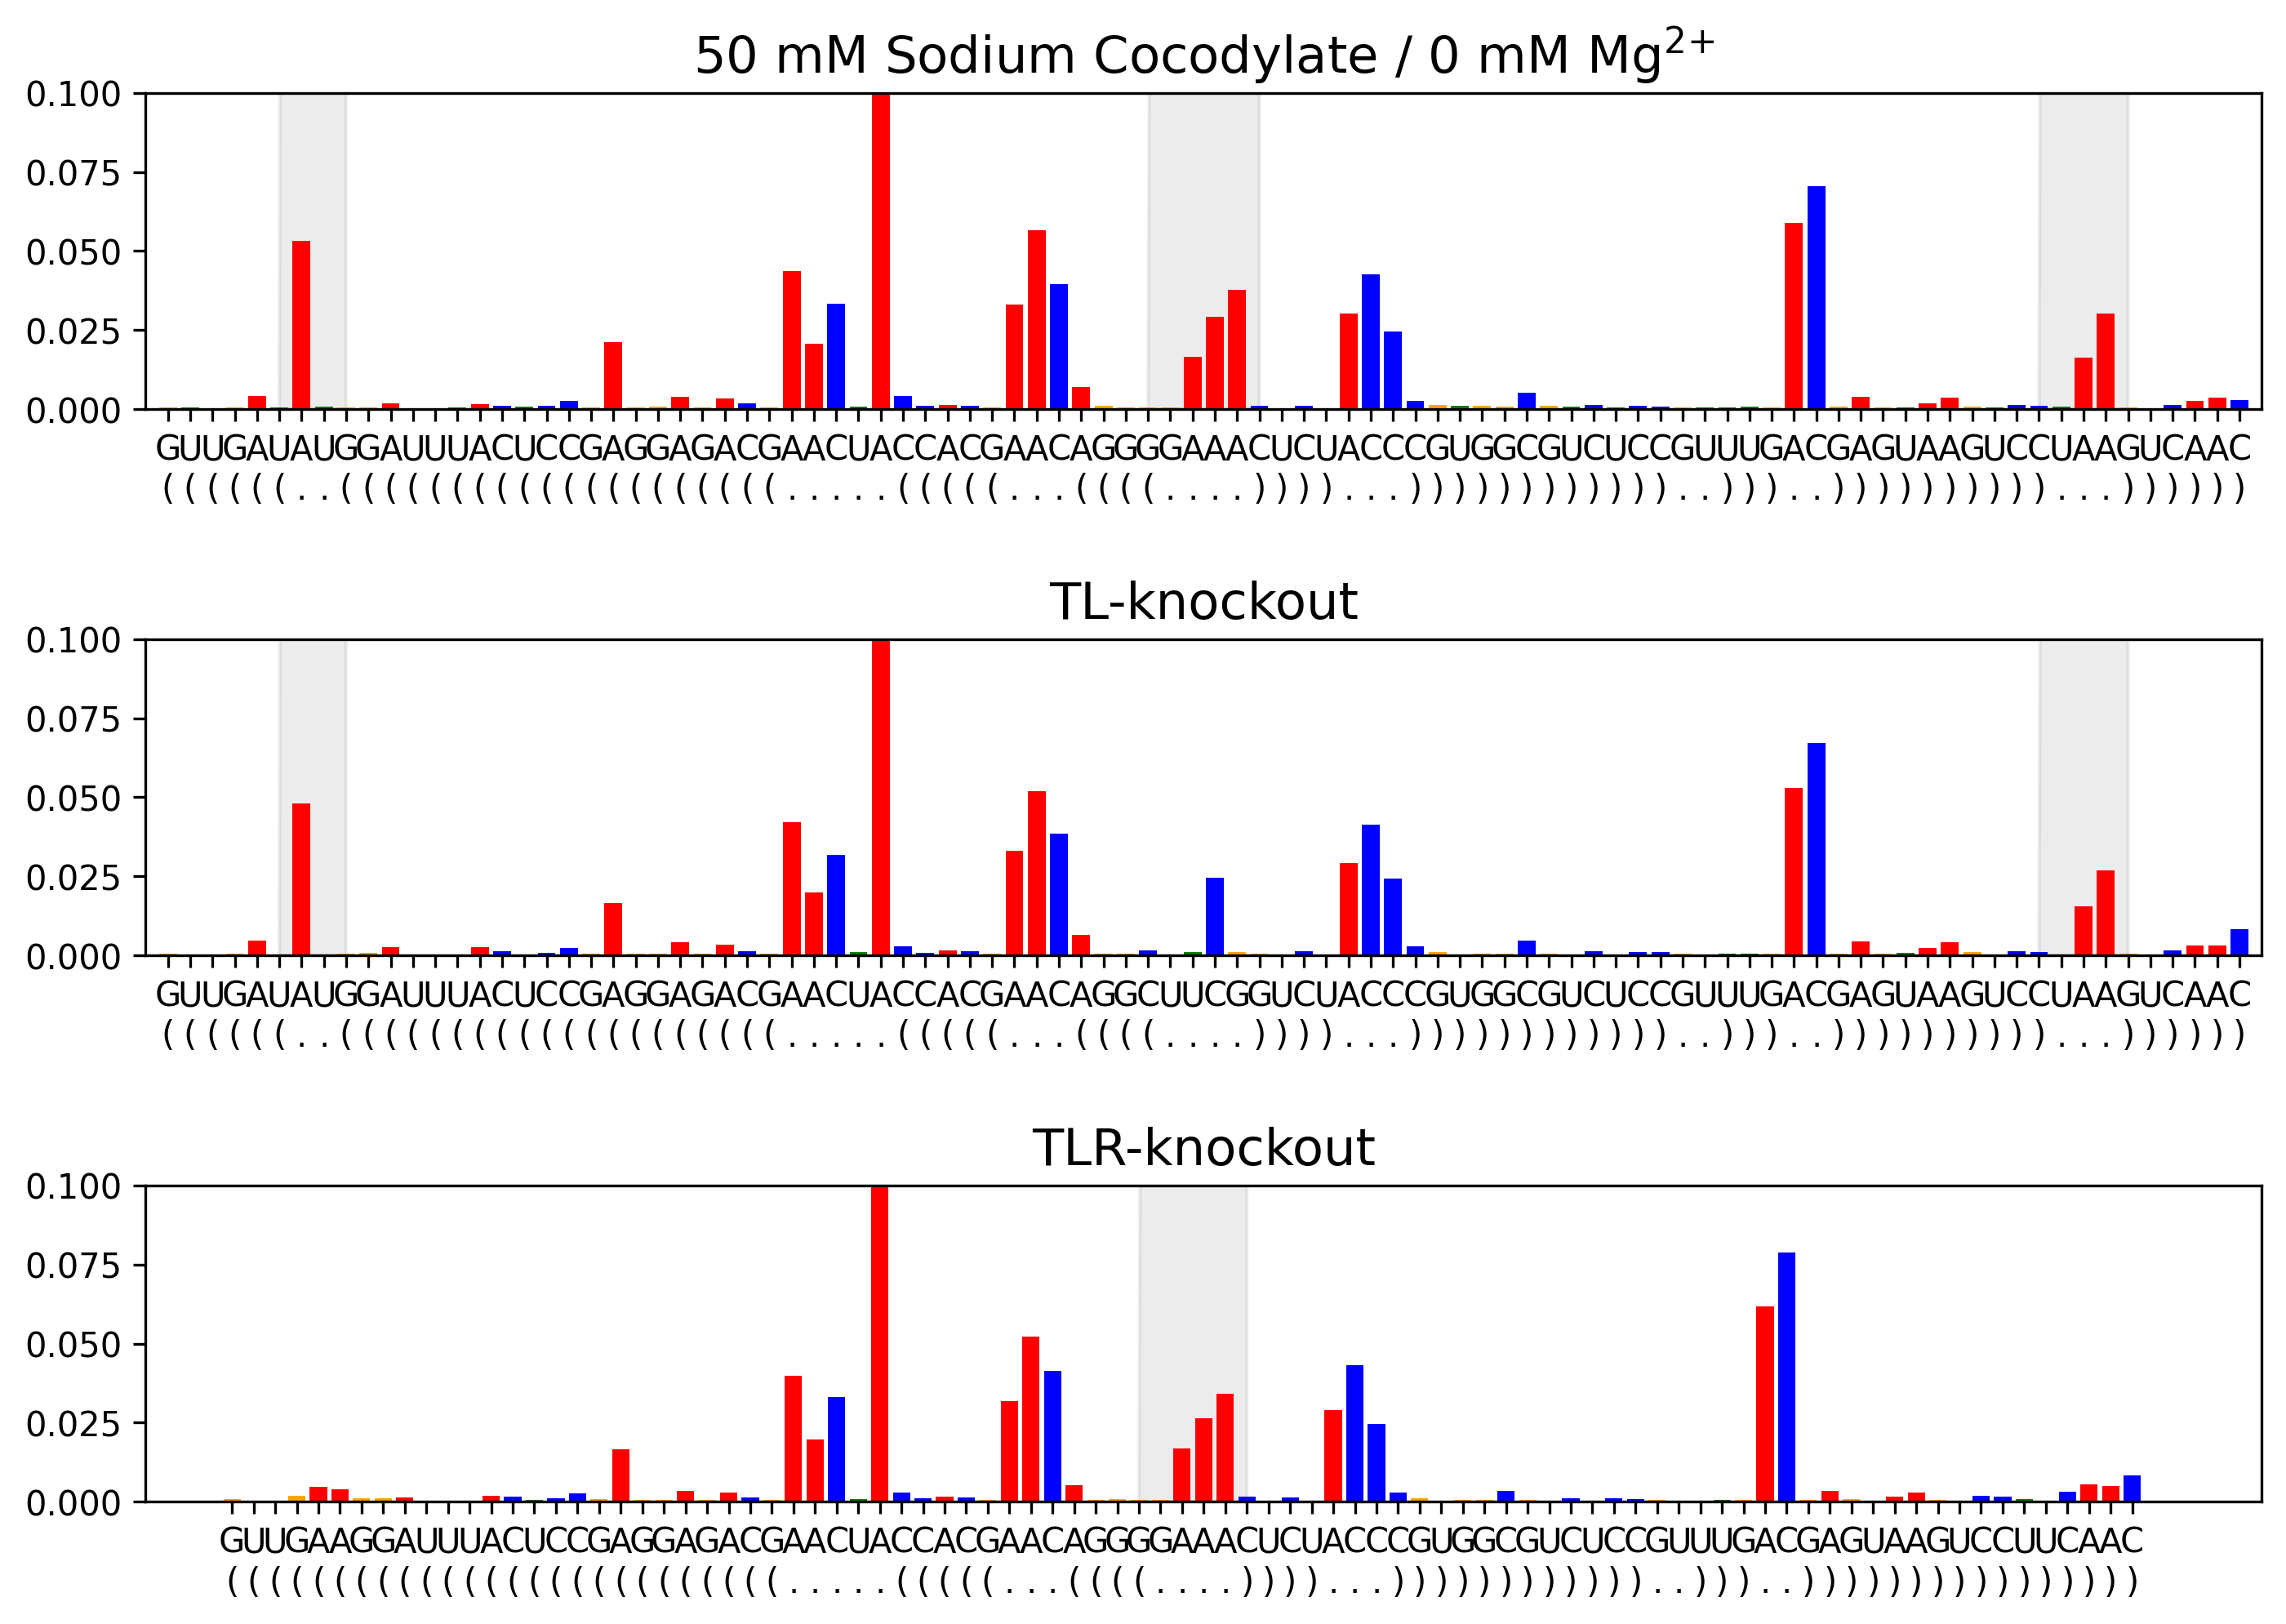

In [9]:
highlights = []
highlights.append({"motif": {"name": "gaaa_tetraloop"}})
highlights.append({"motif": {"name": "tlr"}})
fig, axes = plt.subplots(3, 1, figsize=(10, 7), dpi=300)
plot_pop_avg(wt_w_o_mg["sequence"], wt_w_o_mg["structure"], wt_w_o_mg["data"], ax=axes[0], 
             trim_5p=20, trim_3p=22, highlights=highlights)
axes[0].set_title("50 mM Sodium Cocodylate / 0 mM Mg$^{2\!+}\!$", fontsize=15)
axes[0].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[0].set_ylim([0, 0.1])
axes[0].set_xlim([-1, len(wt_w_o_mg["sequence"]) - 22 - 20])
plot_pop_avg(uucg_w_o_mg["sequence"], uucg_w_o_mg["structure"], uucg_w_o_mg["data"], 
             ax=axes[1], trim_5p=20, trim_3p=0, highlights=[highlights[1]])
axes[1].set_title("TL-knockout", fontsize=15)
axes[1].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[1].set_ylim([0, 0.1])
axes[1].set_xlim([-1, len(uucg_w_o_mg["sequence"]) - 20])
fig.tight_layout()
plot_pop_avg(no_tlr_w_o_mg["sequence"], no_tlr_w_o_mg["structure"], no_tlr_w_o_mg["data"], 
             ax=axes[2], trim_5p=20, trim_3p=0, highlights=[highlights[0]])
axes[2].set_title("TLR-knockout", fontsize=15)
axes[2].set_ylim([0, 0.1])
axes[2].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[2].set_ylim([0, 0.1])
axes[2].set_xlim([-4, len(uucg_w_o_mg["sequence"]) - 20])
#plt.savefig(f"supplemental_figure_6.pdf", bbox_inches='tight')


### Supplemental Figure 20: Reactivity profile of kink turn of C-C pair like the C-C mismatch in the CCUAAC_CAUGG TLR variant. 


In [10]:
wt_w_o_mg = df_wt_mg[(df_wt_mg.mg_conc == 0) & (df_wt_mg.exp_name == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM")].iloc[0]
wt_w_mg = df_wt_mg[(df_wt_mg.mg_conc == 40) & (df_wt_mg.exp_name == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM")].iloc[0]


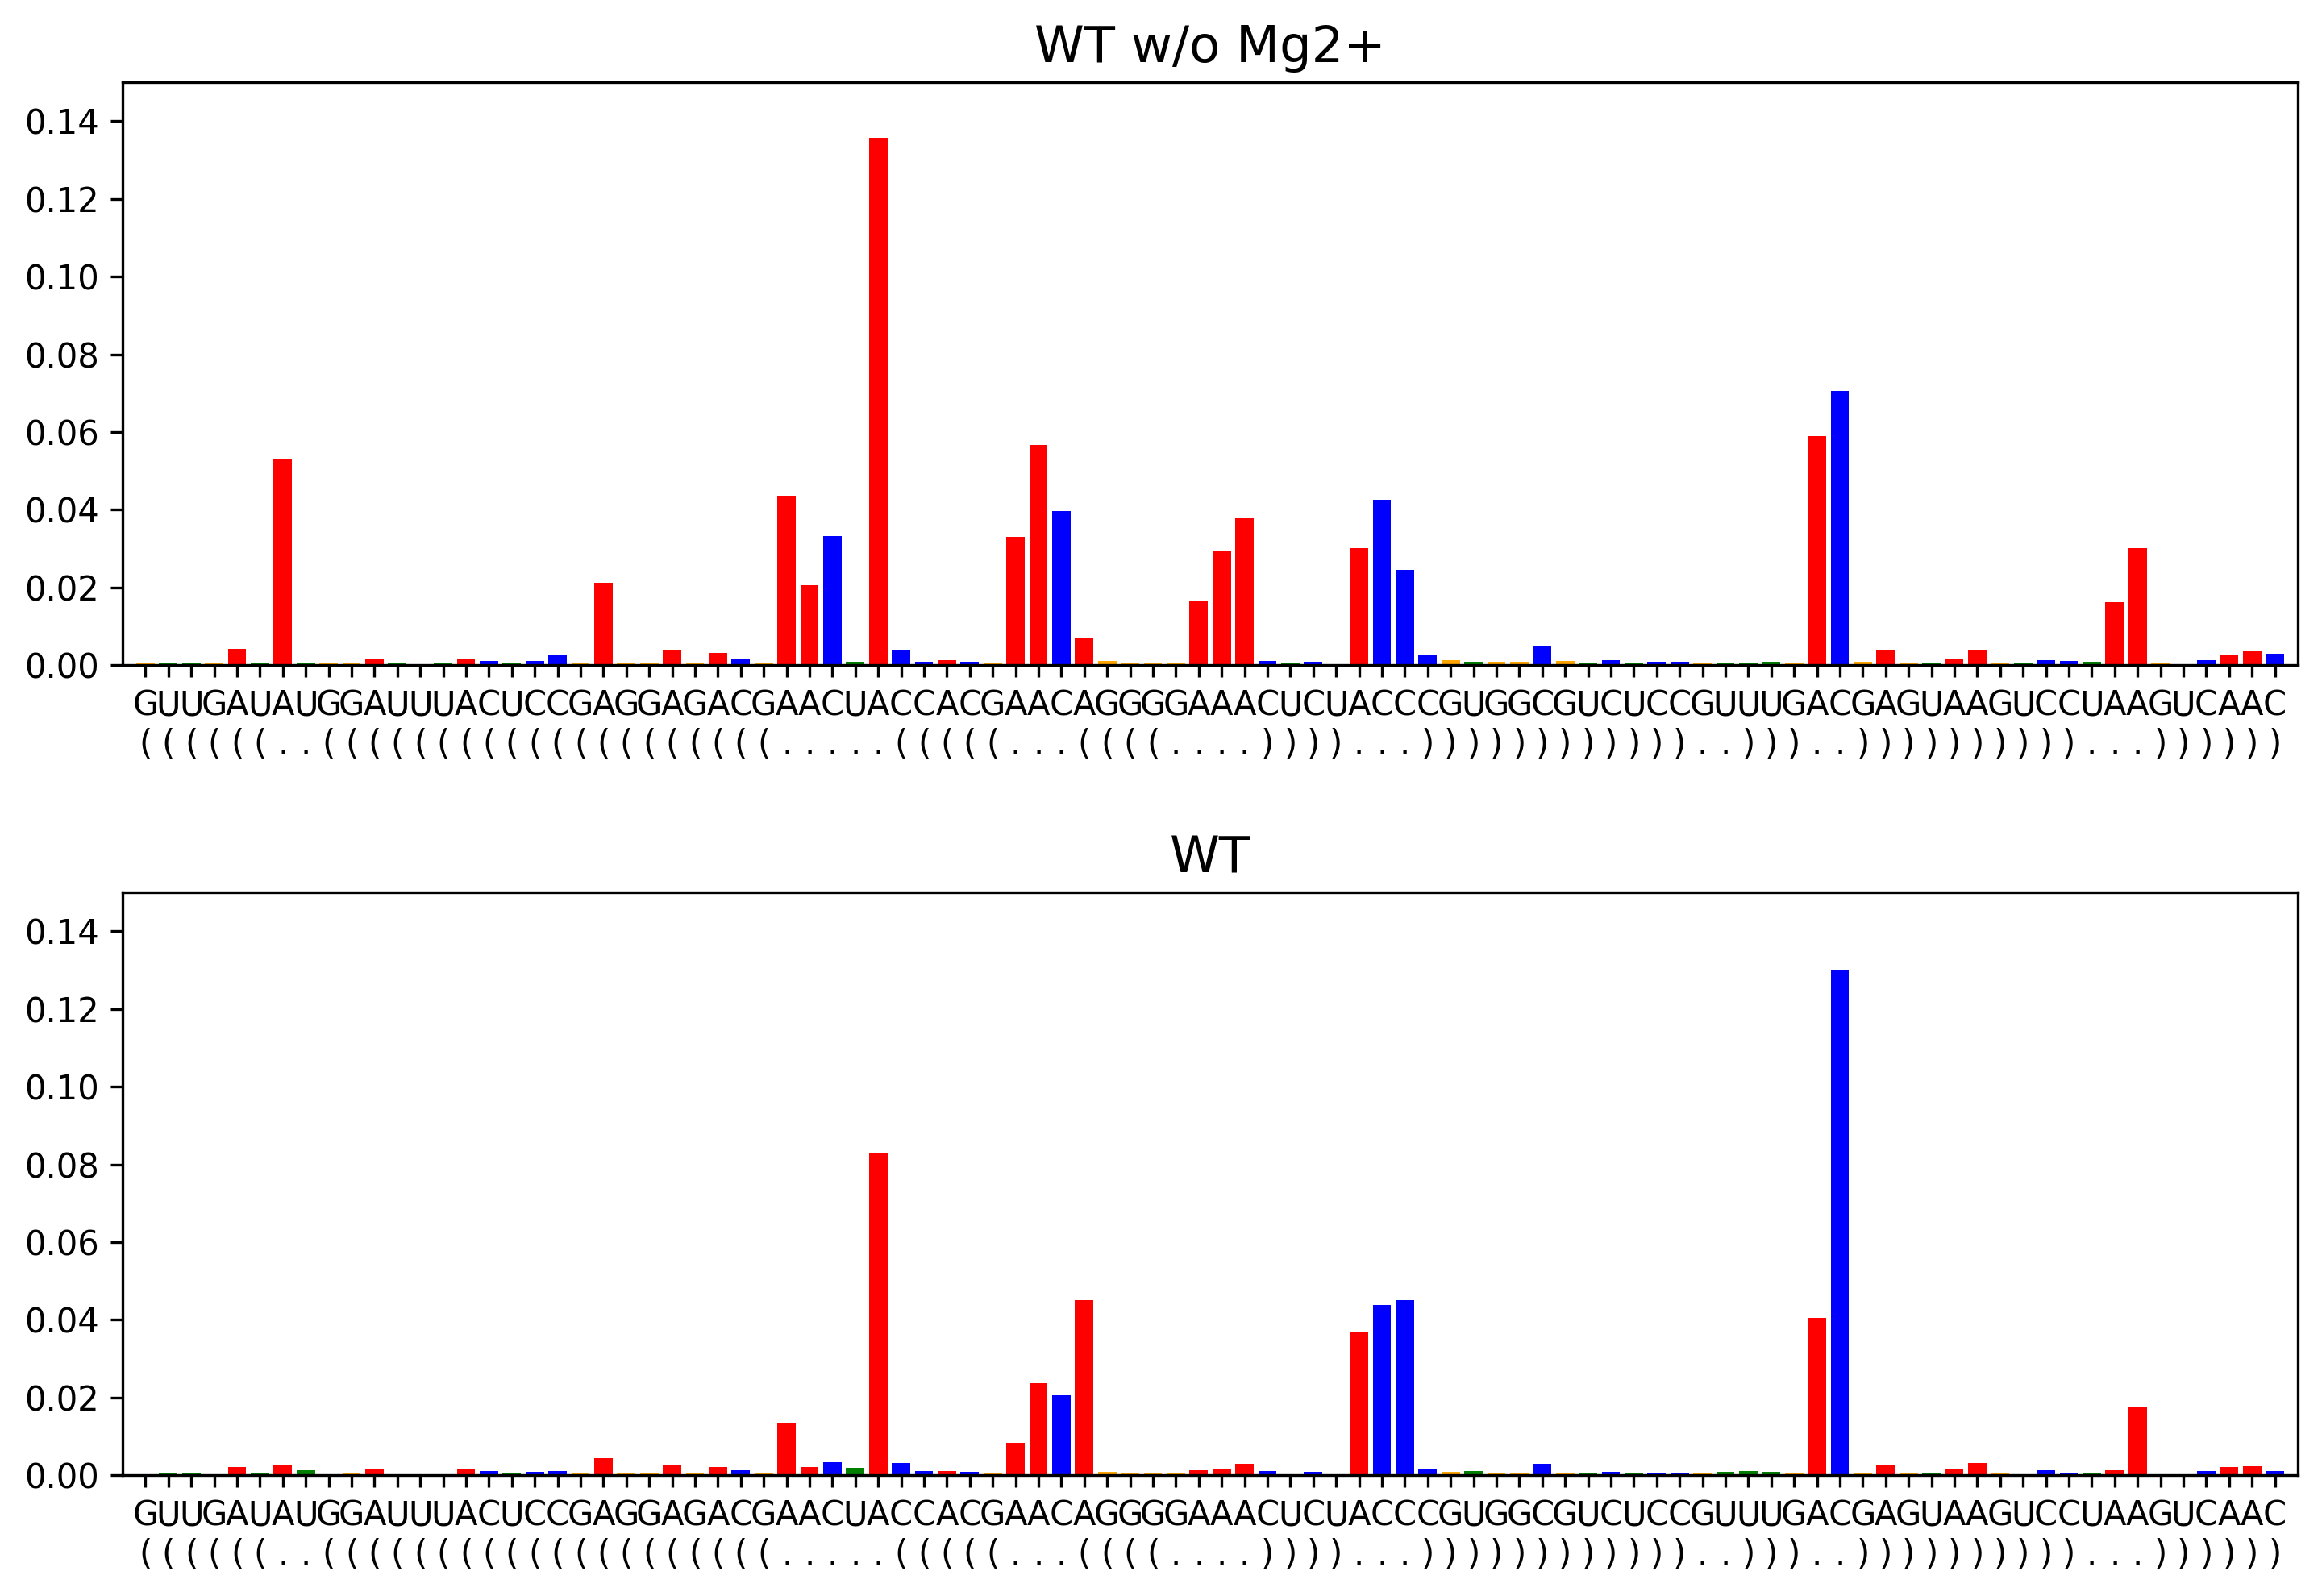

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), dpi=300)
plot_pop_avg(wt_w_o_mg["sequence"], wt_w_o_mg["structure"], wt_w_o_mg["data"], ax=axes[0], 
             trim_5p=20, trim_3p=22)
axes[0].set_title("WT w/o Mg2+", fontsize=15)
axes[0].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[0].set_ylim([0, 0.15])
axes[0].set_xlim([-1, len(wt_w_o_mg["sequence"]) - 22 - 20])
plot_pop_avg(wt_w_mg["sequence"], wt_w_mg["structure"], wt_w_mg["data"], 
             ax=axes[1], trim_5p=20, trim_3p=22)
axes[1].set_title("WT", fontsize=15)
axes[1].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[1].set_ylim([0, 0.15])
axes[1].set_xlim([-1, len(uucg_w_o_mg["sequence"]) - 20])
fig.tight_layout()

### Supplemental Figure 10: Direct correlation between GAAA mutation fraction at 40 mM and Mg2+. 

Text(0, 0.5, 'GAAA Mutation Fraction')

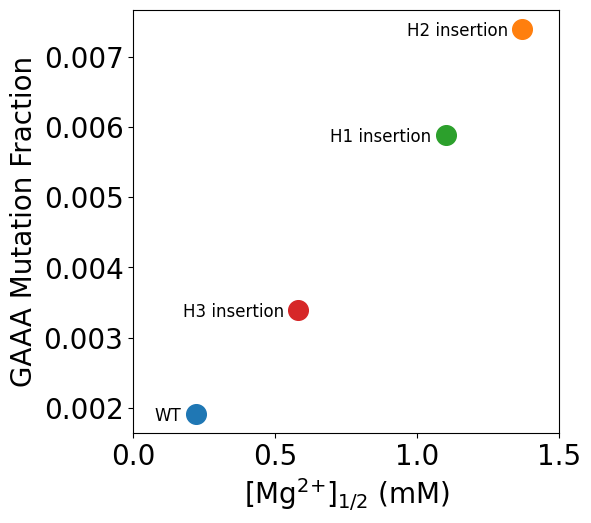

In [28]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
# Your scatter plot data
x_values = [0.22, 1.10, 1.37, 0.58]
y_values = [0.0019166667, 0.0058866667, 0.0073933333, 0.0033966]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
labels = ['WT', 'H1 insertion', 'H2 insertion', 'H3 insertion']  # Replace with your labels

# Create scatter plot
for x, y, c, label in zip(x_values, y_values, colors, labels):
    ax.scatter([x], [y], color=c, s=200)
    ax.text(x-0.05, y-0.00010, label, fontsize=12, ha='right')  # Adjust text properties as needed
ax.set_xlim([0, 1.5])
ax.set_xlabel("[Mg$^{2\!+}\!$]$_{1/2}$ (mM)")
ax.set_ylabel("GAAA Mutation Fraction")

### Supplemental Figure 5: The three As in GAAA have similar reactivity profiles and can be averaged.

In [12]:
df_sub = df_wt_mg[df_wt_mg["buffer_conc"] == 50]

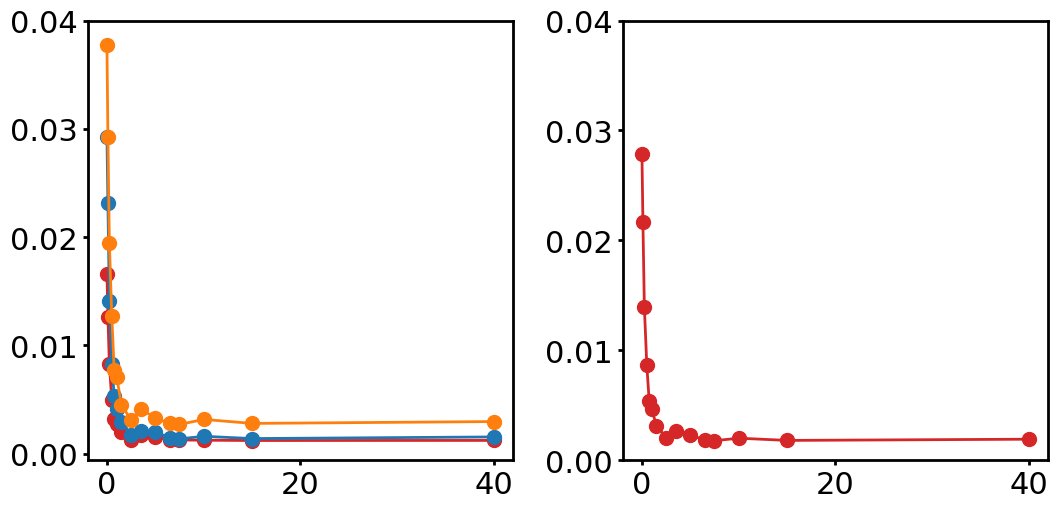

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5.5))
publication_style_ax(ax[0])
publication_line(ax[0], df_sub['mg_conc'], [x[2] for x in df_sub['gaaa']], marker='o', color='tab:red')
publication_line(ax[0], df_sub['mg_conc'], [x[3] for x in df_sub['gaaa']], marker='o', color='tab:blue')
publication_line(ax[0], df_sub['mg_conc'], [x[4] for x in df_sub['gaaa']], marker='o', color='tab:orange')


# averaged
publication_style_ax(ax[1])
publication_line(ax[1], df_sub['mg_conc'], df_sub['gaaa_avg'], marker='o', color='tab:red')

#ax.set_ylabel("Average mutation fraction")
#ax.set_xlabel("Mg    concentration (mM)")
#ax.legend()
ax[0].set_yticks([0.0, 0.01,0.02,0.03,0.04]);
ax[1].set_yticks([0.0, 0.01,0.02,0.03,0.04]);
plt.tight_layout()

### Supplemental Figure 16: correlation between Mg2+/2 and GAAA reactivity

In [43]:
# check supplemental table 4 for reasons
exclude = [
    "UCUAAA_CAUGA",
    "CCUACA_UACGG",
    "CUUAAC_UAUGG",
    "CCUCAC_CACGG",
    "GCUCAA_CAUGC",
    "GCUGAA_CAUGC",
    "CCUCAA_CAUGG",
    "CCUGAA_CAUGG",
    "CCUAAAG_UAAGG",
    "CCUAAC_UAGGG",
    "CCUCAC_UAUGG",
]

df_sub = df_dg[~df_dg["name"].isin(exclude)].copy()
df_sub['mg_1_2'] = df_sub['mg_1_2'].astype(float)
df_sub_mg = df_mttr6_full[df_mttr6_full["mg_conc"] == 7.5]
df_sub = df_sub_mg.merge(df_dg, on="name")
df_sub = df_sub[df_sub["mg_1_2"] < 10]


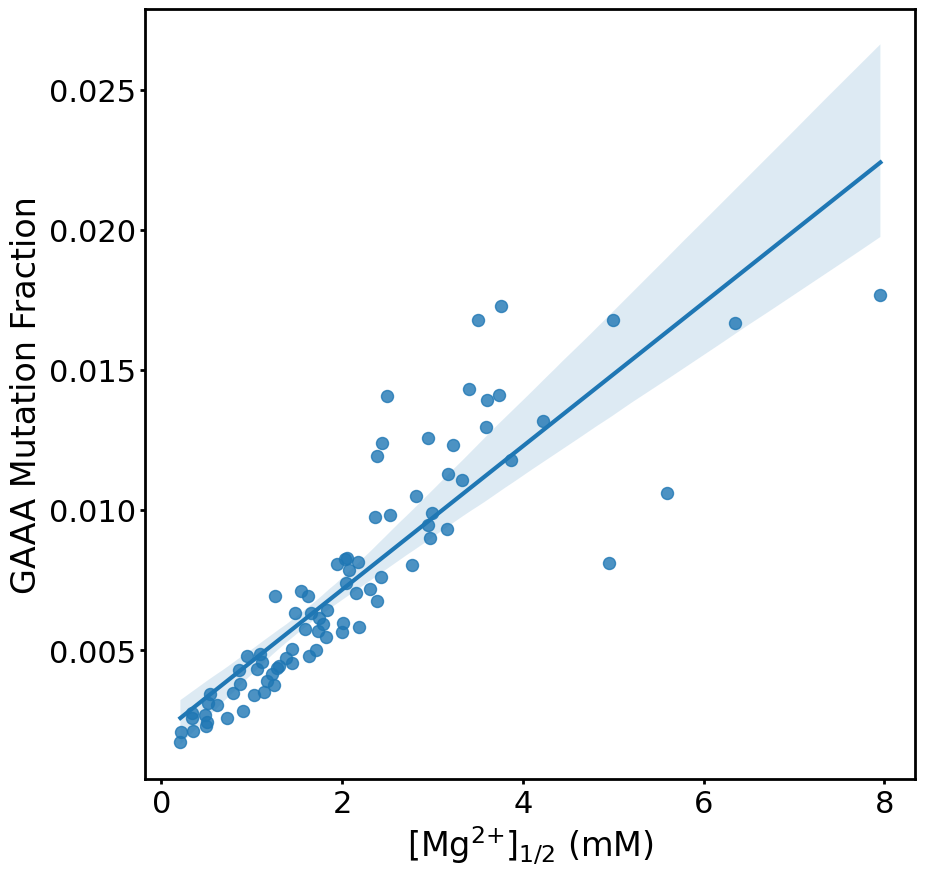

In [41]:
ax = sns.regplot(x="mg_1_2", y="gaaa_avg", data=df_sub, scatter_kws={"s": 75}, line_kws={"lw" : 3})
ax.set_box_aspect(1)
ax.set_xlabel("[Mg$^{2\!+}\!$]$_{1/2}$ (mM)")
ax.set_ylabel("GAAA Mutation Fraction")
publication_style_ax(ax)

In [42]:
r2(df_sub["mg_1_2"], df_sub["gaaa_avg"])

0.766

### Supplemental Figure 4: Change of pH over time as a function of different sodium cacodylate buffer concentrations.

Text(0, 0.5, 'pH')

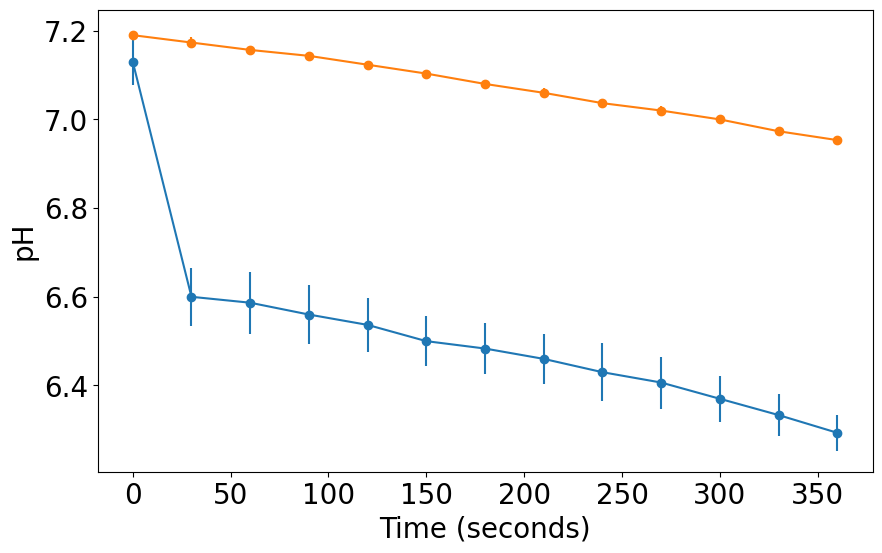

In [35]:
# Load the CSV files
file_50_mm = '../../data/ph_tests/50_mm_na_coc.csv'
file_300_mm = '../../data/ph_tests/300_mm_na_coc.csv'

data_50_mm = pd.read_csv(file_50_mm)
data_300_mm = pd.read_csv(file_300_mm)

# Calculate the average and standard deviation of pH for each time point
avg_50_mm = data_50_mm.groupby('time')['ph'].mean()
std_50_mm = data_50_mm.groupby('time')['ph'].std()

avg_300_mm = data_300_mm.groupby('time')['ph'].mean()
std_300_mm = data_300_mm.groupby('time')['ph'].std()

# Plot the data with error bars
plt.figure(figsize=(10, 6))

# Plot for 50 mM NaCOC
plt.errorbar(avg_50_mm.index, avg_50_mm, yerr=std_50_mm, label='50 mM NaCOC', fmt='-o')

# Plot for 300 mM NaCOC
plt.errorbar(avg_300_mm.index, avg_300_mm, yerr=std_300_mm, label='300 mM NaCOC', fmt='-o')

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('pH')



### Supplemental Figure 11: The reactivity of each DMS active residue as a function of Mg2+ in the 3x3 motif. 

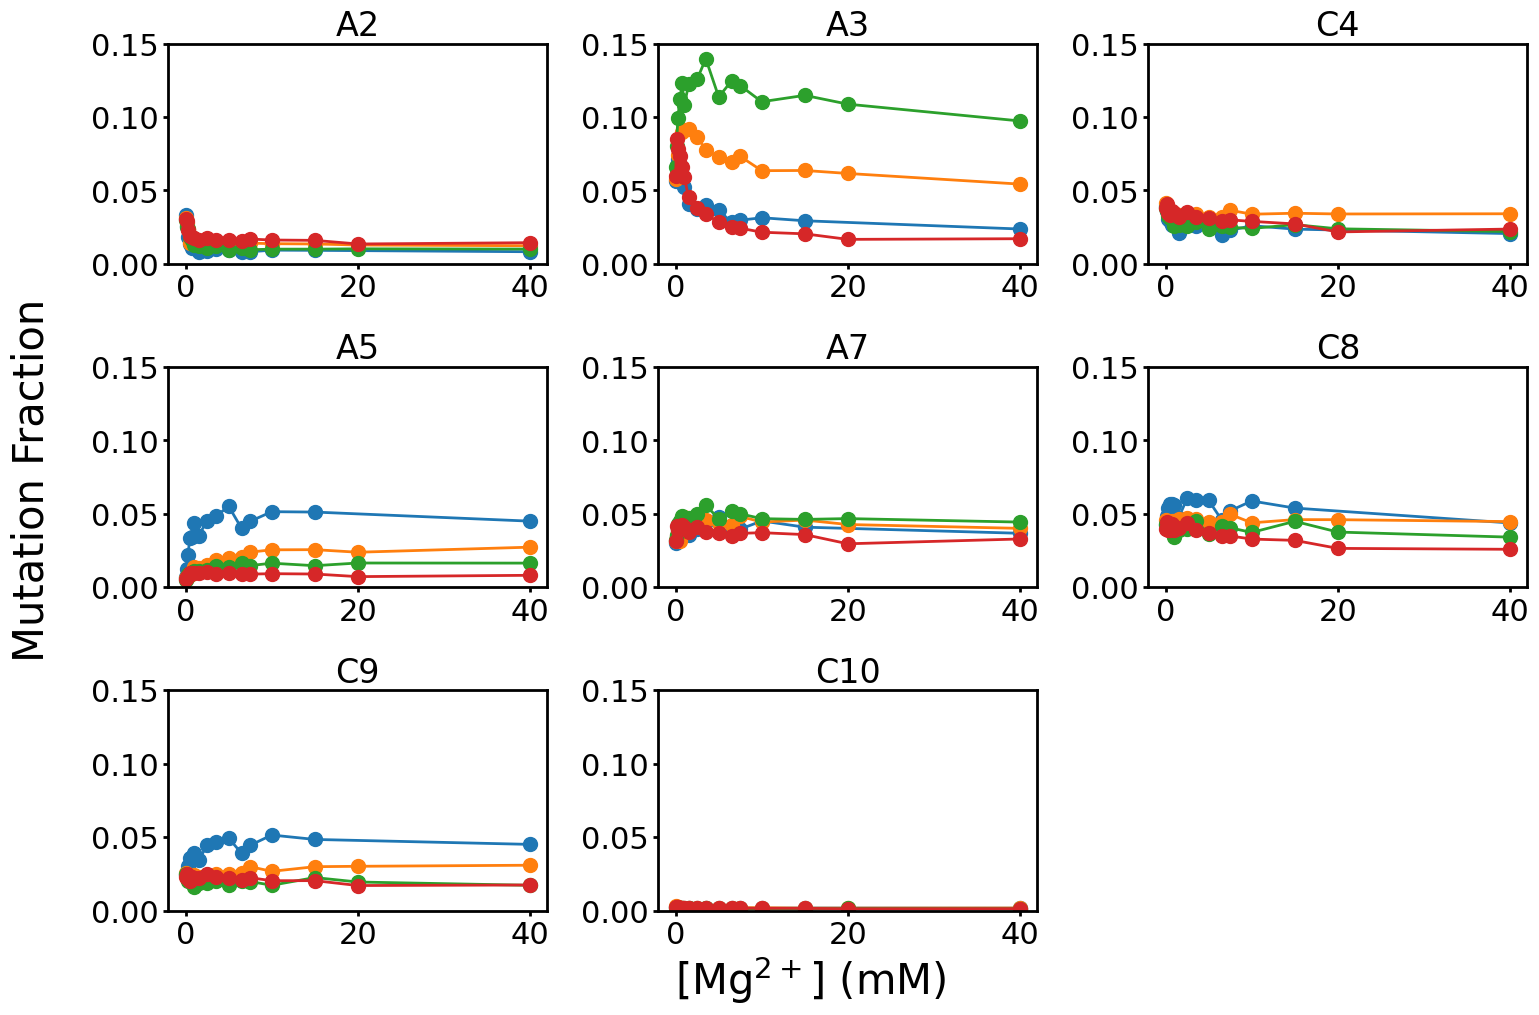

In [37]:
df_wt_1 = df_wt_mg[(df_wt_mg["buffer_conc"] == 50)]
df_h1_ins = df_mttr6_muts[(df_mttr6_muts["name"] == "minittr_6_h1_3bp_longer_fixed")]
df_h2_ins = df_mttr6_muts[(df_mttr6_muts["name"] == "minittr_6_h2_3bp_longer_fixed")]
df_h3_ins = df_mttr6_muts[(df_mttr6_muts["name"] == "minittr_6_h3_3bp_longer_fixed")]
dfs = [df_wt_1, df_h1_ins, df_h2_ins, df_h3_ins]
seq = "GAACA&UACCC"
name = "3x3_motif"
compare_all_nuc_motifs(dfs, seq, name)


### Supplemental Figure 13: The reactivity of each DMS active residue as a function of Mg2+ in the kink-turn motif.

14


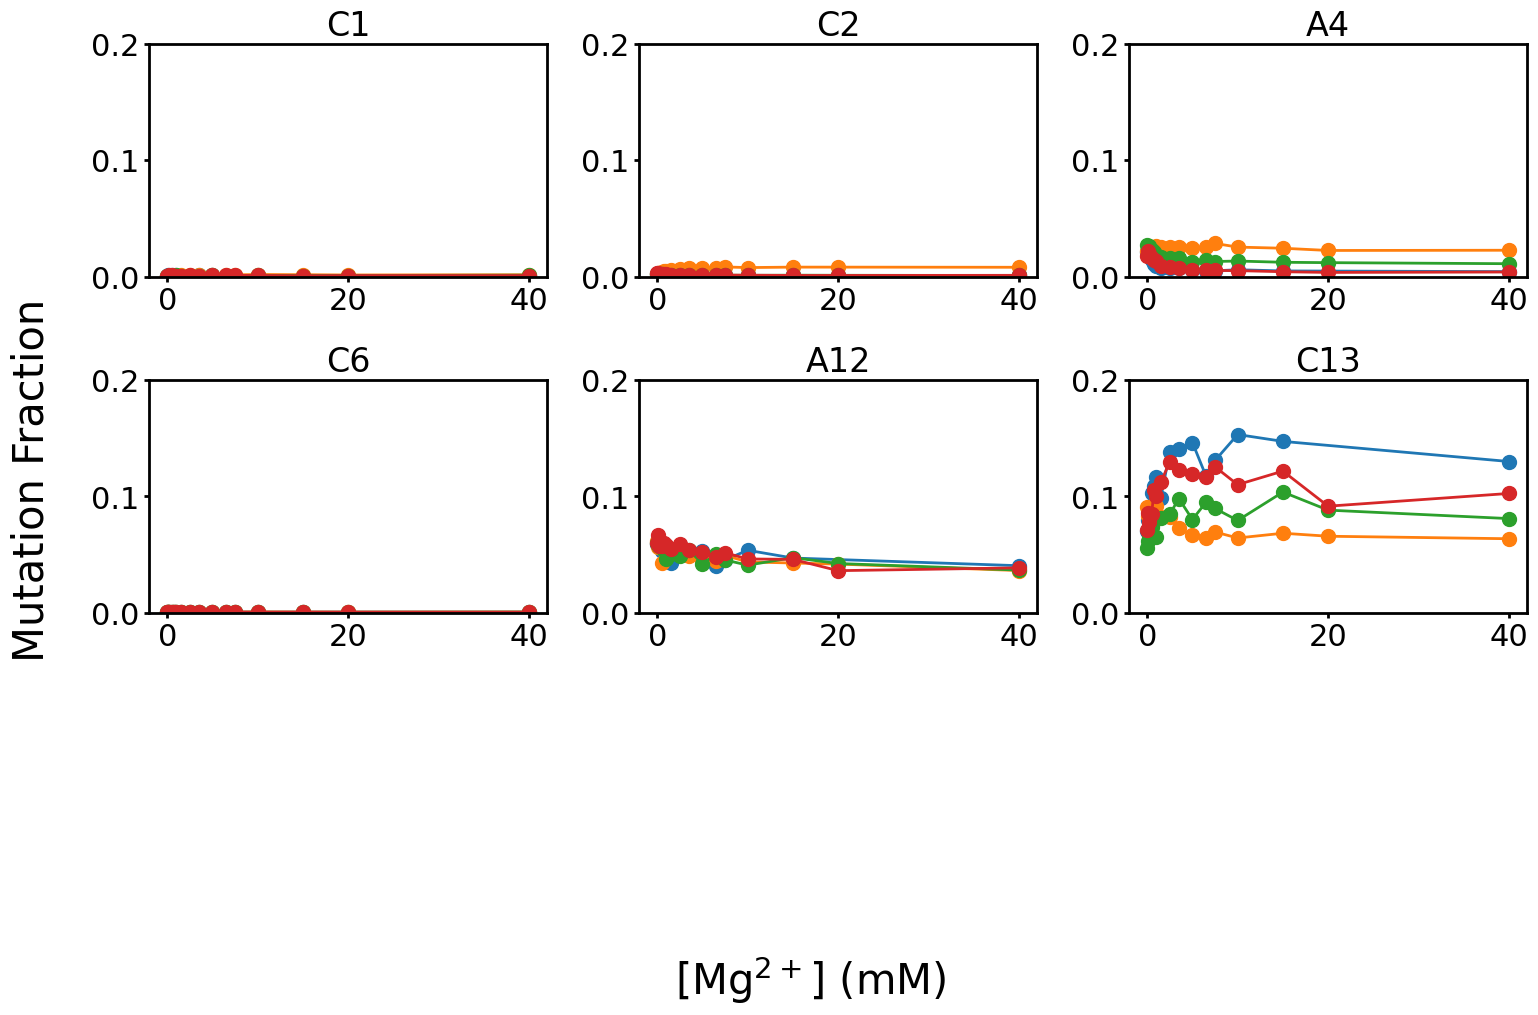

In [38]:
seq = "CCGAG&CGUUUGACG"
name = "kink_turn"
print(len(dfs[0].iloc[0][name]))
compare_all_nuc_motifs(dfs, seq, name, ylim=0.20)

### Supplemental Figure 12: The reactivity of each DMS active residue as a function of Mg2+ in the IRES motif.

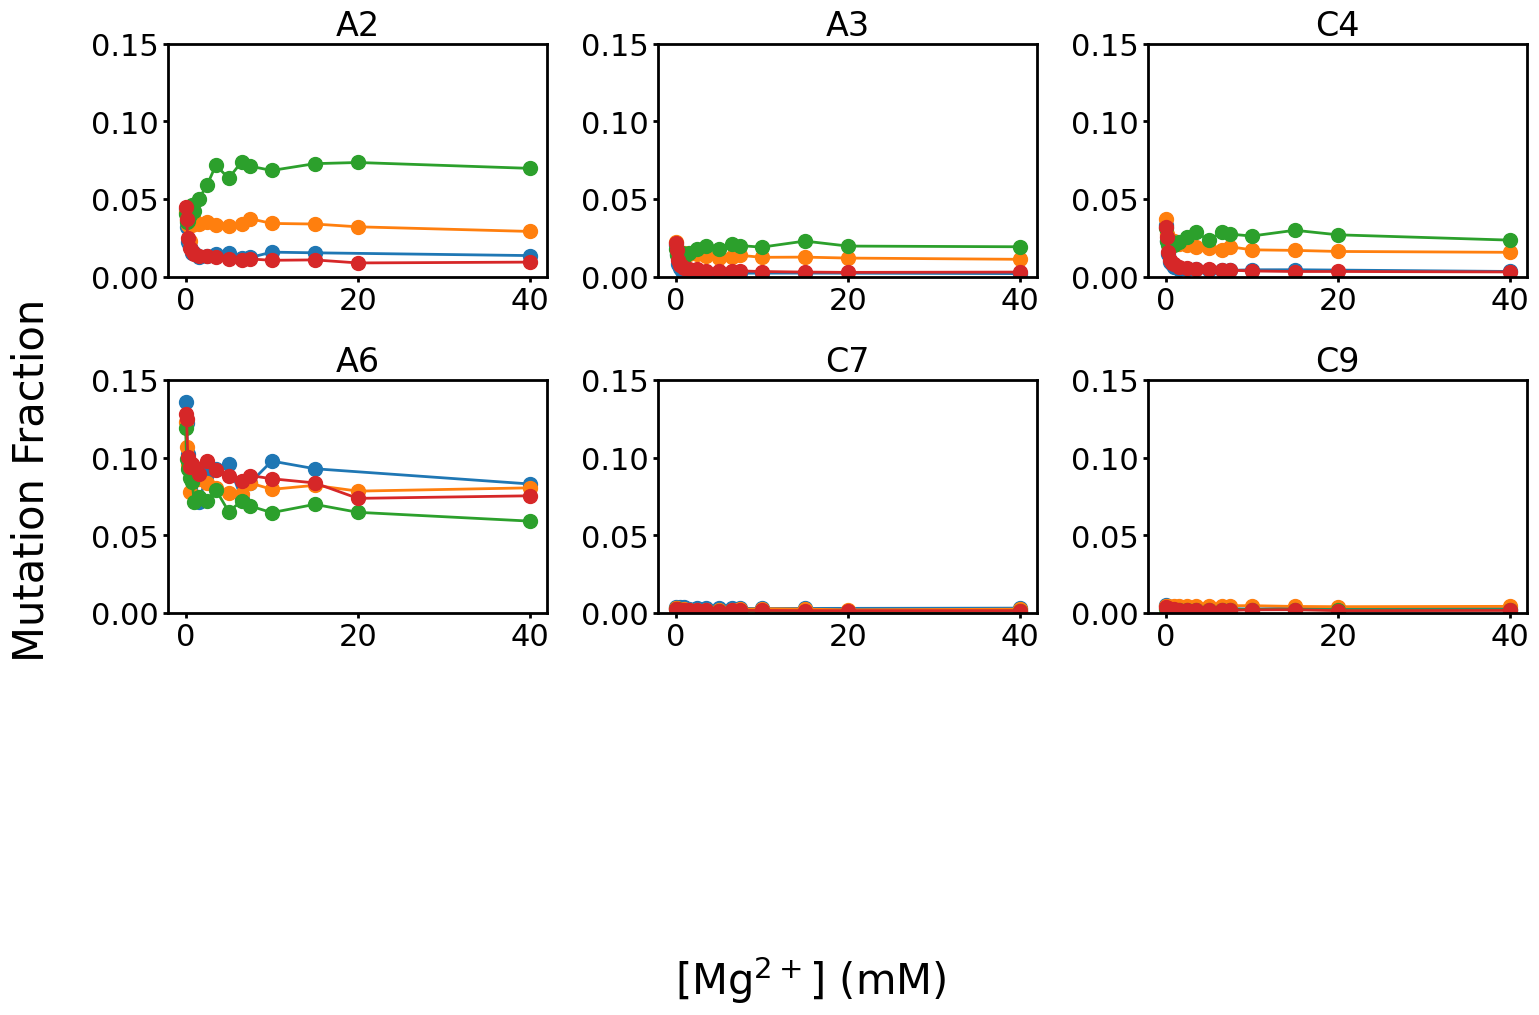

In [39]:
seq = "GAACUACGC"
name = "ires"
compare_all_nuc_motifs(dfs, seq, name)

### Supplemental Figure 18: Hierarchical clustering of reactivity values for the tetraloop and the tetraloop receptor DMS active residues. 

In [47]:
df_mttr6_full = df_mttr6_full[df_mttr6_full["mg_conc"] != 5.0]

names = []
all_data = []
for i, group in df_mttr6_full.groupby('name'):
    group = group.sort_values('mg_conc')
    data = []
    data.extend(group['gaaa'].apply(lambda x : x[2]))
    data.extend(group['gaaa'].apply(lambda x : x[3]))
    data.extend(group['gaaa'].apply(lambda x : x[4]))
    data.extend(group['tlr'].apply(lambda x : x[3]))
    data.extend(group['tlr'].apply(lambda x : x[4]))
    data.extend(group['tlr'].apply(lambda x : x[7]))

    names.append(i)    
    all_data.append(data)

# Create a DataFrame from the data matrix for better labeling
data_df = pd.DataFrame(all_data, index=names)

In [48]:
Z = linkage(all_data, method='ward')
max_d = 0.25  # Adjust this value based on your specific needs
clusters = fcluster(Z, max_d, criterion='distance')
data_df['cluster'] = clusters

df_sorted = data_df.sort_values(by='cluster')
data_matrix = all_data
data_df_new = pd.DataFrame(data_matrix, index=names)
data_df_sorted = data_df_new.loc[df_sorted.index]

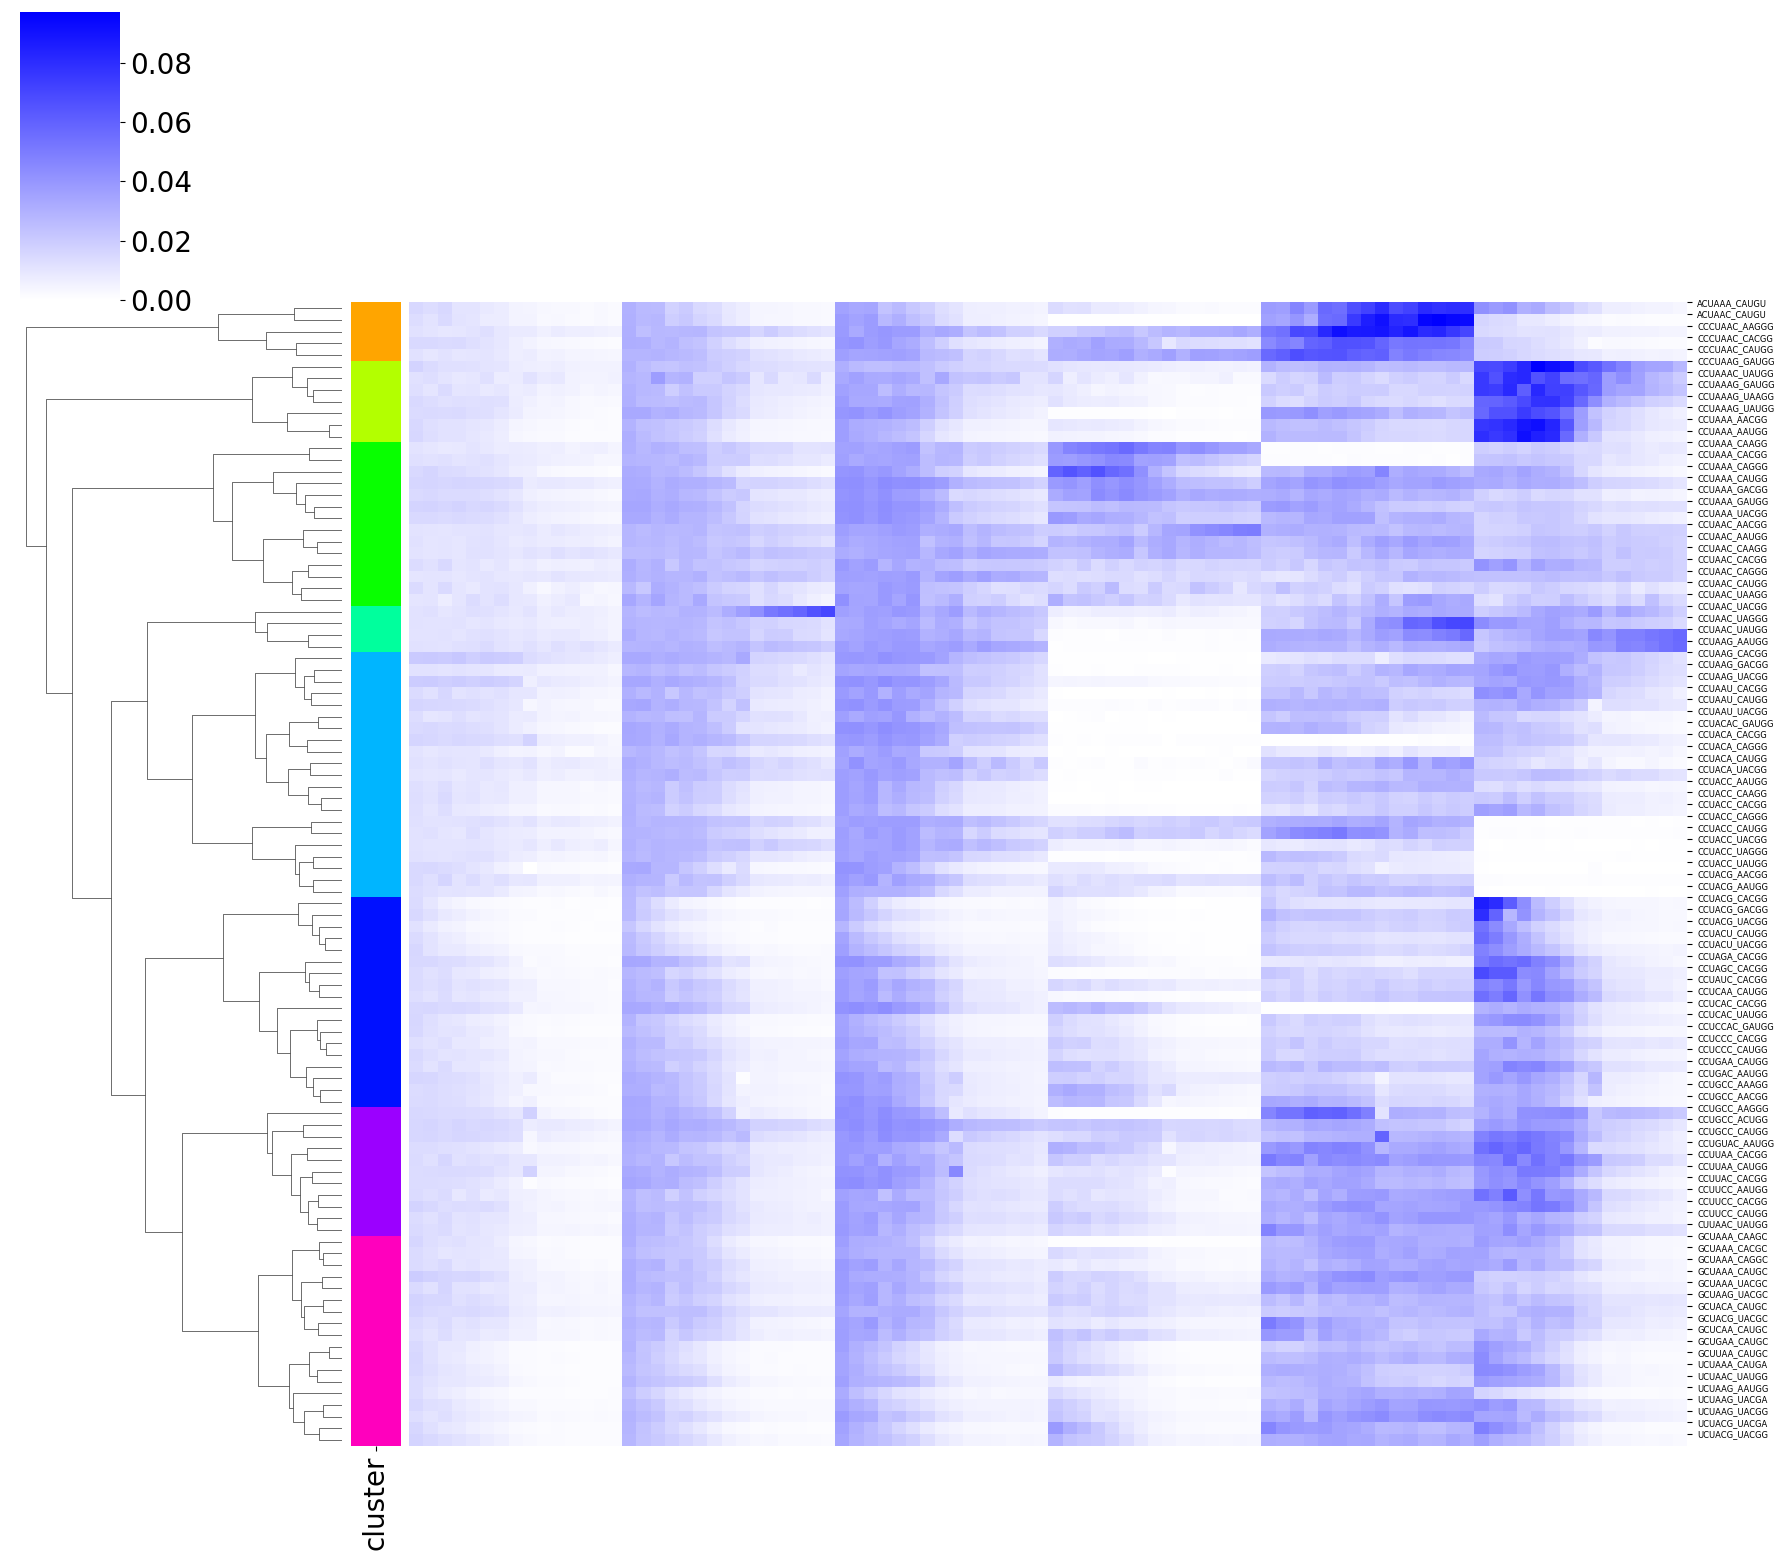

In [49]:
# Create a custom colormap that transitions from white to blue
colors = [(1, 1, 1), (0, 0, 1)]  # white to blue
cmap_name = 'white_to_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Map clusters to colors
unique_clusters = df_sorted['cluster'].unique()
cluster_palette = sns.color_palette("hsv", len(unique_clusters))
cluster_lut = dict(zip(unique_clusters, cluster_palette))
row_colors = df_sorted['cluster'].map(cluster_lut)

# Create the clustermap with the sorted DataFrame and row colors
clustermap2 = sns.clustermap(data_df_sorted, method='ward', cmap=cmap, col_cluster=False,
                            row_colors=row_colors, figsize=(20, 16))
clustermap2.ax_heatmap.set_xticks([]);
clustermap2.ax_heatmap.set_yticks(range(0, len(data_df)), rotation=0, labels=data_df.index, size=6);

In [49]:
for i, group in data_df.groupby('cluster'):
    print(i, len(group), group.index)

1 5 Index(['AACGG_CCUACG', 'AAUGG_CCUACC', 'AAUGG_CCUACG', 'AAUGG_CCUUCC',
       'CAAGG_CCUACC'],
      dtype='object')
2 7 Index(['AAAGG_CCUGCC', 'CAGGC_GCUAAA', 'CAGGG_CCUAAC', 'CAUGA_UCUAAA',
       'CAUGC_GCUAAA', 'CAUGU_ACUAAA', 'UAGGG_CCUAAC'],
      dtype='object')
3 14 Index(['AAUGG_CCUAAG', 'AAUGG_UCUAAG', 'CACGG_CCUAAG', 'CACGG_CCUAGA',
       'CACGG_CCUAGC', 'CACGG_CCUCAC', 'CAUGC_GCUCAA', 'CAUGG_CCUAAU',
       'CAUGG_CCUACU', 'CAUGG_CCUCAA', 'CAUGG_CCUCCC', 'GACGG_CCUACG',
       'UACGG_CCUACA', 'UAUGG_CCUCAC'],
      dtype='object')
4 4 Index(['CAUGC_GCUGAA', 'CAUGG_CCUGAA', 'GACGG_CCUAAA', 'UAUGG_CUUAAC'], dtype='object')
5 21 Index(['AACGG_CCUAAA', 'AAGGG_CCCUAAC', 'AAUGG_CCUGUAC', 'ACUGG_CCUGCC',
       'CACGG_CCCUAAC', 'CACGG_CCUUAA', 'CACGG_CCUUAC', 'CACGG_CCUUCC',
       'CAUGC_GCUUAA', 'CAUGG_CCCUAAC', 'CAUGG_CCUGCC', 'CAUGG_CCUUAA',
       'CAUGG_CCUUCC', 'GAUGG_CCCUAAG', 'GAUGG_CCUAAAG', 'GAUGG_CCUACAC',
       'GAUGG_CCUCCAC', 'UAAGG_CCUAAAG', 'UACGG_CCUAAA', '

### Supplemental Figure 19: The sequence information for each variant in each color. All highlighted colors are mutations from the wild-type. Colors simply help show the mutations A is red, C is blue, G is yellow, and U is green.

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


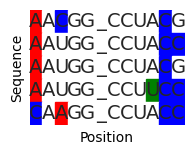

In [53]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUACG', 'AAUGG_CCUACC', 'AAUGG_CCUACG', 'AAUGG_CCUUCC',
       'CAAGG_CCUACC']
plot_sequences_by_mutation(wt_seq, cluster_seqs)


/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


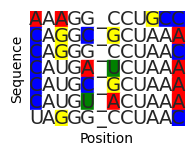

In [54]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AAAGG_CCUGCC', 'CAGGC_GCUAAA', 'CAGGG_CCUAAC', 'CAUGA_UCUAAA',
       'CAUGC_GCUAAA', 'CAUGU_ACUAAA', 'UAGGG_CCUAAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs)

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


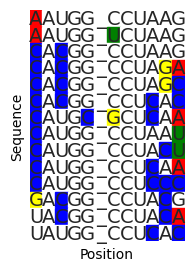

In [55]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AAUGG_CCUAAG', 'AAUGG_UCUAAG', 'CACGG_CCUAAG', 'CACGG_CCUAGA',
       'CACGG_CCUAGC', 'CACGG_CCUCAC', 'CAUGC_GCUCAA', 'CAUGG_CCUAAU',
       'CAUGG_CCUACU', 'CAUGG_CCUCAA', 'CAUGG_CCUCCC', 'GACGG_CCUACG',
       'UACGG_CCUACA', 'UAUGG_CCUCAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 3))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


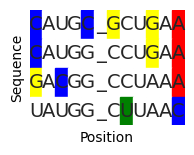

In [56]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['CAUGC_GCUGAA', 'CAUGG_CCUGAA', 'GACGG_CCUAAA', 'UAUGG_CUUAAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs)

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


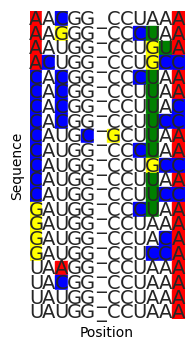

In [57]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUAAA', 'AAGGG_CCCUAAC', 'AAUGG_CCUGUAC', 'ACUGG_CCUGCC',
       'CACGG_CCCUAAC', 'CACGG_CCUUAA', 'CACGG_CCUUAC', 'CACGG_CCUUCC',
       'CAUGC_GCUUAA', 'CAUGG_CCCUAAC', 'CAUGG_CCUGCC', 'CAUGG_CCUUAA',
       'CAUGG_CCUUCC', 'GAUGG_CCCUAAG', 'GAUGG_CCUAAAG', 'GAUGG_CCUACAC',
       'GAUGG_CCUCCAC', 'UAAGG_CCUAAAG', 'UACGG_CCUAAA', 'UAUGG_CCUAAAC',
       'UAUGG_CCUAAAG']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 4))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


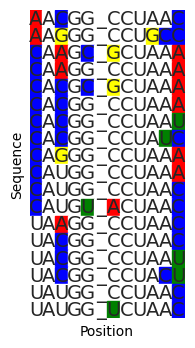

In [58]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUAAC', 'AAGGG_CCUGCC', 'CAAGC_GCUAAA', 'CAAGG_CCUAAA',
       'CACGC_GCUAAA', 'CACGG_CCUAAA', 'CACGG_CCUAAU', 'CACGG_CCUAUC',
       'CAGGG_CCUAAA', 'CAUGG_CCUAAA', 'CAUGG_CCUAAC', 'CAUGU_ACUAAC',
       'UAAGG_CCUAAC', 'UACGG_CCUAAC', 'UACGG_CCUAAU', 'UACGG_CCUACU',
       'UAUGG_CCUAAC', 'UAUGG_UCUAAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 4))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


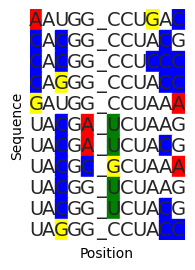

In [59]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AAUGG_CCUGAC', 'CACGG_CCUACG', 'CACGG_CCUCCC', 'CAGGG_CCUACC',
       'GAUGG_CCUAAA', 'UACGA_UCUAAG', 'UACGA_UCUACG', 'UACGC_GCUAAA',
       'UACGG_UCUAAG', 'UACGG_UCUACG', 'UAGGG_CCUACC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 3))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


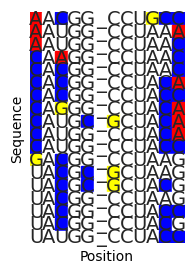

In [60]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUGCC', 'AAUGG_CCUAAA', 'AAUGG_CCUAAC', 'CAAGG_CCUAAC',
       'CACGG_CCUAAC', 'CACGG_CCUACA', 'CACGG_CCUACC', 'CAGGG_CCUACA',
       'CAUGC_GCUACA', 'CAUGG_CCUACA', 'CAUGG_CCUACC', 'GACGG_CCUAAG',
       'UACGC_GCUAAG', 'UACGC_GCUACG', 'UACGG_CCUAAG', 'UACGG_CCUACC',
       'UACGG_CCUACG', 'UAUGG_CCUACC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 3))